In [79]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ROOT
from pathlib import Path
import mplhep as hep

hep.style.use(hep.style.ATLAS)

import re
import joblib
import logging
from utils.utils import check_inputpath, check_outputpath, logging_setup

In [46]:
logging_setup(verbosity=4, if_write_log=False, output_path=Path("output"))

# Comapre GM 450GeV 

In [2]:
GM_sig_m450_path = "../Run2_WZ_samples/GM_sig/resonance.450770_MGaMcAtNloPy8EG_A14NNPDF23LO_vbfGM_sH05_H5pWZ_lvll_m450_ntuples.root"
GM_sig_m450_path = Path(GM_sig_m450_path)

## Cutflow

In [5]:
GMH5_m450_ROOT = ROOT.TFile.Open(GM_sig_m450_path.as_posix())
GMH5_m450_ROOT.ls()

TFile**		../Run2_WZ_samples/GM_sig/resonance.450770_MGaMcAtNloPy8EG_A14NNPDF23LO_vbfGM_sH05_H5pWZ_lvll_m450_ntuples.root	
 TFile*		../Run2_WZ_samples/GM_sig/resonance.450770_MGaMcAtNloPy8EG_A14NNPDF23LO_vbfGM_sH05_H5pWZ_lvll_m450_ntuples.root	
  KEY: TH1D	lumiRegister;1	lumiRegister
  KEY: TH1D	event_CutFlow;1	event_CutFlow
  KEY: TTree	nominal;1	nominal


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


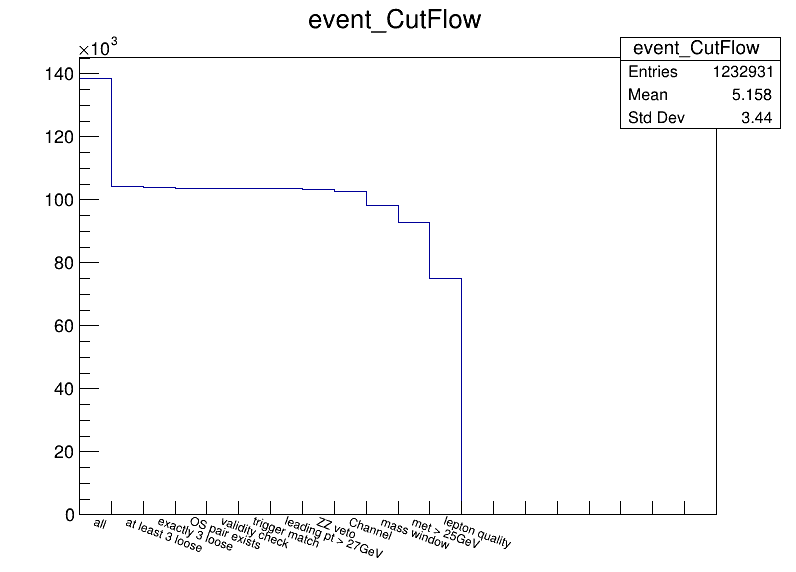

In [7]:
c1 = ROOT.TCanvas("c1", "c1", 800, 600)
GMH5_m450_ROOT.Get("event_CutFlow").Draw()
c1.Draw()

In [8]:
event_CutFlow = GMH5_m450_ROOT.Get("event_CutFlow")
cut_name = []
cut_yield = []
for i in range(1, 15):
    cut_name.append(event_CutFlow.GetXaxis().GetBinLabel(i))
    cut_yield.append(event_CutFlow.GetBinContent(i))

pd.DataFrame({"cut_name": cut_name, "cut_yield": cut_yield})

,cut_name,cut_yield
0,all,138405.0
1,at least 3 loose,104155.0
2,exactly 3 loose,104052.0
3,OS pair exists,103569.0
4,validity check,103569.0
5,trigger match,103564.0
6,leading pt > 27GeV,103516.0
7,ZZ veto,103270.0
8,Channel,102555.0
9,mass window,98300.0


## Check GM H5 mass = 450 GeV

In [9]:
GM_sig_m450 = uproot.open(GM_sig_m450_path)

In [10]:
GM_sig_m450.keys()

['lumiRegister;1', 'event_CutFlow;1', 'nominal;1']

In [19]:
nominal_branchs = GM_sig_m450["nominal"].keys()[0:93]
GM_sig_m450_nominal_branches = GM_sig_m450["nominal"].arrays(
    nominal_branchs, library="pd"
)

In [22]:
print(nominal_branchs)

['Yields', 'isMC', 'Channel', 'Year', 'NormSF', 'WeightSign', 'WeightNormalized', 'Weight', 'M_WZ', 'M_123', 'Mt_WZ', 'M_Z', 'Mt_W', 'Met', 'Njets', 'NBjets', 'SumOfWeight', 'Luminosity', 'CrossSection', 'WZInclusiveLoose', 'WZInclusive', 'WZqqSR', 'WZqqCR', 'WZVBSSR', 'WZVBSCR', 'ZfakeElCR', 'ZfakeMuCR', 'ZfakeCR', 'TopElCR', 'TopMuCR', 'TopCR', 'ZZCR', 'EventNumber', 'AvMu', 'M_jj', 'Deta_jj', 'DY_jj', 'Dphi_jj', 'PtBalanceZ', 'PtBalanceW', 'ZetaLep', 'Sum3Pt', 'Pt_123', 'Pt_WZ', 'Pt_W', 'Pt_Z', 'Eta_W', 'Eta_Z', 'LTcode', 'TruthType', 'genMass', 'Jet1Pt', 'Jet2Pt', 'Jet3Pt', 'Jet1Eta', 'Jet2Eta', 'Jet3Eta', 'Jet1Phi', 'Jet2Phi', 'Jet3Phi', 'Jet1E', 'Jet2E', 'Jet3E', 'Jet1Y', 'Jet2Y', 'Jet3Y', 'Jet1Truth', 'Jet2Truth', 'Jet3Truth', 'Lep1Pt', 'Lep2Pt', 'Lep3Pt', 'Lep1Eta', 'Lep2Eta', 'Lep3Eta', 'Lep1Phi', 'Lep2Phi', 'Lep3Phi', 'Lep1Charge', 'Lep2Charge', 'Lep3Charge', 'Lep1D0Sig', 'Lep2D0Sig', 'Lep3D0Sig', 'Lep1WeightZ', 'Lep2WeightZ', 'Lep3WeightZ', 'Lep1WeightW', 'Lep2WeightW', 'Lep

In [54]:
##### Add cuts accrording to the table 1
cut_GM_sig_m450 = GM_sig_m450_nominal_branches.copy()
training_cutflow = {}
# WZInclusive
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["WZInclusive"] == 1]
training_cutflow["Cut WZInclusive"] = len(cut_GM_sig_m450)
print(f"Cut WZInclusive: {len(cut_GM_sig_m450)}")

# N_j >= 2
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["Njets"] >= 2]
training_cutflow["Cut Njets>=2"] = len(cut_GM_sig_m450)
print(f"Cut Njets>=2: {len(cut_GM_sig_m450)}")

# b-jet veto
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["NBjets"] == 0]
training_cutflow["Cut NBjets==0"] = len(cut_GM_sig_m450)
print(f"Cut NBjets==0: {len(cut_GM_sig_m450)}")

# M_jj > 25 GeV
cut_GM_sig_m450 = cut_GM_sig_m450.loc[cut_GM_sig_m450["M_jj"] >= 25]
training_cutflow["Cut M_jj>100GeV"] = len(cut_GM_sig_m450)
print(f"Cut M_jj>100GeV: {len(cut_GM_sig_m450)}")

training_cutflow = pd.DataFrame(
    {
        "training_cutflow": training_cutflow.keys(),
        "cut_yield": training_cutflow.values(),
    }
)

Cut WZInclusive: 75096
Cut Njets>=2: 43702
Cut NBjets==0: 42699
Cut M_jj>100GeV: 42579


In [55]:
training_cutflow

,training_cutflow,cut_yield
0,WZInclusive,75096
1,Cut Njets>=2,43702
2,Cut NBjets==0,42699
3,Cut M_jj>100GeV,42579


# Check all H5 masses

In [56]:
##### Reproduce table 11

In [57]:
input_path = "../Run2_WZ_samples/"
input_path = Path(input_path)
check_inputpath(input_path)

GM_sig_path = input_path / "GM_sig"

In [72]:
def apply_training_cut(GM_sig_m_nominal_branches):
    cut_GM_sig_m = GM_sig_m_nominal_branches.copy()
    training_cutflow = {}
    # WZInclusive
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["WZInclusive"] == 1]
    training_cutflow["Cut WZInclusive"] = len(cut_GM_sig_m)

    # N_j >= 2
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["Njets"] >= 2]
    training_cutflow["Cut Njets>=2"] = len(cut_GM_sig_m)

    # b-jet veto
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["NBjets"] == 0]
    training_cutflow["Cut NBjets==0"] = len(cut_GM_sig_m)

    # M_jj > 25 GeV
    cut_GM_sig_m = cut_GM_sig_m.loc[cut_GM_sig_m["M_jj"] >= 25]
    training_cutflow["Cut M_jj>100GeV"] = len(cut_GM_sig_m)

    training_cutflow = pd.DataFrame(
        {
            "training_cutflow": training_cutflow.keys(),
            "cut_yield": training_cutflow.values(),
        }
    )

    raw_event_yield = len(cut_GM_sig_m)
    normalized_event_yield = cut_GM_sig_m["WeightNormalized"].sum()

    return (
        cut_GM_sig_m,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    )

In [73]:
training_input_yield = {
    "mass": [],
    "raw_event_yield": [],
    "normalized_event_yield": [],
}

re_mass_pattern = r"m(\d+)(?=[_ntuples,_lepfilt])"

merged_sig = []

for GM_sig_file in sorted(GM_sig_path.glob("*.root")):
    GM_sig_file_name = GM_sig_file.name
    match = re.search(re_mass_pattern, GM_sig_file_name)
    if match:
        mass = match.group(1)
        mass = int(mass)
    else:
        raise ValueError("No mass found in file name")

    GM_sig_file = uproot.open(GM_sig_file)
    nominal_branchs = GM_sig_file["nominal"].keys()[0:93]
    GM_sig_m_nominal_branches = GM_sig_file["nominal"].arrays(
        nominal_branchs, library="pd"
    )

    (
        cut_GM_sig_m,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    ) = apply_training_cut(GM_sig_m_nominal_branches)

    merged_sig.append(cut_GM_sig_m)
    training_input_yield["mass"].append(mass)
    training_input_yield["raw_event_yield"].append(raw_event_yield)
    training_input_yield["normalized_event_yield"].append(
        normalized_event_yield
    )

In [74]:
training_input_yield = pd.DataFrame(training_input_yield)
merged_sig = pd.concat(merged_sig)

In [77]:
training_input_yield.loc["Total"] = training_input_yield.sum()

In [78]:
training_input_yield

,mass,raw_event_yield,normalized_event_yield
0,200.0,12864.0,163.386871
1,250.0,28754.0,152.360809
2,300.0,32416.0,145.596329
3,350.0,39447.0,136.016647
4,400.0,44222.0,121.478531
5,450.0,42579.0,97.893768
6,500.0,49375.0,86.848808
7,225.0,25021.0,158.082687
8,275.0,31403.0,155.481232
9,325.0,37137.0,135.885498


In [80]:
joblib.dump(merged_sig, "merged_sig.pkl")

['merged_sig.pkl']

# Merge Bkg

In [82]:
bkg_path = input_path / "bkg"
check_inputpath(bkg_path)

PosixPath('../Run2_WZ_samples/bkg')

In [83]:
test_bkg_file = sorted(bkg_path.glob("*.root"))[0]

In [91]:
training_input_yield_bkg = {
    "name": [],
    "raw_event_yield": [],
    "normalized_event_yield": [],
}

merged_bkg = []

for bkg_file in sorted(bkg_path.glob("*.root")):
    bkg_file_name = bkg_file.name
    bkg_file = uproot.open(bkg_file)
    nominal_branchs = test_bkg_file["nominal"].keys()[0:93]
    bkg_nominal_branches = bkg_file["nominal"].arrays(
        nominal_branchs, library="pd"
    )

    (
        cut_bkg,
        training_cutflow,
        raw_event_yield,
        normalized_event_yield,
    ) = apply_training_cut(bkg_nominal_branches)
    merged_bkg.append(cut_bkg)
    training_input_yield_bkg["name"].append(bkg_file_name)
    training_input_yield_bkg["raw_event_yield"].append(raw_event_yield)
    training_input_yield_bkg["normalized_event_yield"].append(
        normalized_event_yield
    )

In [92]:
training_input_yield_bkg = pd.DataFrame(training_input_yield_bkg)

In [94]:
training_input_yield_bkg.loc["Total"] = training_input_yield_bkg.sum()

In [95]:
training_input_yield_bkg

,name,raw_event_yield,normalized_event_yield
0,resonance.364253_Sherpa_222_NNPDF30NNLO_lllv_n...,1011527,3820.449463
1,resonance.364739_MGPy8EG_NNPDF30NLO_A14NNPDF23...,30240,47.728439
2,resonance.364740_MGPy8EG_NNPDF30NLO_A14NNPDF23...,40427,74.232010
3,resonance.364741_MGPy8EG_NNPDF30NLO_A14NNPDF23...,28768,45.244751
4,resonance.364742_MGPy8EG_NNPDF30NLO_A14NNPDF23...,34554,70.241791
Total,resonance.364253_Sherpa_222_NNPDF30NNLO_lllv_n...,1145516,4057.896484


In [96]:
merged_bkg = pd.concat(merged_bkg)

In [97]:
merged_bkg

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep3D0Sig,Lep1WeightZ,Lep2WeightZ,Lep3WeightZ,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level
0,0,364253,1,1516,0.030810,-1.0,0.004270,0.138590,307.253082,224.885284,...,0.353855,0.988461,0.996163,0.996026,0.984322,0.988816,0.999972,123,123,123
3,0,364253,1,1516,0.030810,-1.0,0.003436,0.111508,264.512421,162.948868,...,-2.186435,0.985945,0.986804,0.976912,0.984519,0.966683,0.972876,123,123,123
7,0,364253,2,1516,0.030810,-1.0,0.001967,0.063848,581.739746,542.020996,...,0.680584,0.974916,0.996505,0.994135,0.963180,0.991485,0.989407,123,123,123
8,0,364253,1,1516,0.030810,-1.0,0.004380,0.142154,180.702271,126.432777,...,-0.338391,0.990487,0.995481,0.996336,0.982291,0.992726,0.993438,123,123,123
9,0,364253,1,1516,0.030810,-1.0,0.003606,0.117033,421.647491,330.038269,...,-0.423846,0.997536,0.992484,0.989995,0.997536,0.987993,0.990398,122,123,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144734,0,364742,1,18,861.184753,-1.0,0.002414,0.000003,336.063995,236.209488,...,-0.037377,0.988371,0.988767,0.990528,0.985891,0.974431,0.981239,123,123,123
144745,0,364742,1,18,861.184753,-1.0,0.002274,0.000003,239.878281,113.605942,...,0.264748,0.994004,0.987952,0.991782,0.994166,0.997019,0.989058,123,123,123
144748,0,364742,4,18,861.184753,-1.0,0.002322,0.000003,738.158936,507.948669,...,0.442280,0.984904,0.989284,0.985886,0.984712,0.975563,0.981364,123,123,123
144749,0,364742,1,18,861.184753,-1.0,0.001890,0.000002,352.047180,260.609436,...,-0.421180,0.995591,0.991737,0.991675,0.991228,0.990452,0.978599,123,123,123


In [98]:
joblib.dump(merged_bkg, "merged_bkg.pkl")

['merged_bkg.pkl']

# Signal vs Bkg 

In [99]:
plots_path = Path("./plots_sigvsbkg")
check_outputpath(plots_path)

PosixPath('plots_sigvsbkg')

In [101]:
merged_sig.columns

Index(['Yields', 'isMC', 'Channel', 'Year', 'NormSF', 'WeightSign',
       'WeightNormalized', 'Weight', 'M_WZ', 'M_123', 'Mt_WZ', 'M_Z', 'Mt_W',
       'Met', 'Njets', 'NBjets', 'SumOfWeight', 'Luminosity', 'CrossSection',
       'WZInclusiveLoose', 'WZInclusive', 'WZqqSR', 'WZqqCR', 'WZVBSSR',
       'WZVBSCR', 'ZfakeElCR', 'ZfakeMuCR', 'ZfakeCR', 'TopElCR', 'TopMuCR',
       'TopCR', 'ZZCR', 'EventNumber', 'AvMu', 'M_jj', 'Deta_jj', 'DY_jj',
       'Dphi_jj', 'PtBalanceZ', 'PtBalanceW', 'ZetaLep', 'Sum3Pt', 'Pt_123',
       'Pt_WZ', 'Pt_W', 'Pt_Z', 'Eta_W', 'Eta_Z', 'LTcode', 'TruthType',
       'genMass', 'Jet1Pt', 'Jet2Pt', 'Jet3Pt', 'Jet1Eta', 'Jet2Eta',
       'Jet3Eta', 'Jet1Phi', 'Jet2Phi', 'Jet3Phi', 'Jet1E', 'Jet2E', 'Jet3E',
       'Jet1Y', 'Jet2Y', 'Jet3Y', 'Jet1Truth', 'Jet2Truth', 'Jet3Truth',
       'Lep1Pt', 'Lep2Pt', 'Lep3Pt', 'Lep1Eta', 'Lep2Eta', 'Lep3Eta',
       'Lep1Phi', 'Lep2Phi', 'Lep3Phi', 'Lep1Charge', 'Lep2Charge',
       'Lep3Charge', 'Lep1D0Sig', 'Lep2D0S

In [131]:
def compare_sigvsbkg(feature, merged_sig, merged_bkg):
    feature_min = np.min(
        [np.min(merged_sig[feature]), np.min(merged_bkg[feature])]
    )
    feature_max = np.max(
        [np.max(merged_sig[feature]), np.max(merged_bkg[feature])]
    )
    if feature == "M_jj":
        feature_min = 0
        feature_max = 5000
    elif feature == "Met":
        feature_min = 0
        feature_max = 400
    elif feature == "Jet1Pt":
        feature_min = 0
        feature_max = 600
    elif feature == "Jet2Pt":
        feature_min = 0
        feature_max = 300
    elif feature == "Mt_WZ":
        feature_min = 0
        feature_max = 1500

    feature_bins = np.linspace(feature_min, feature_max, 101)
    sig_bin_contents, sig_bin_edges = np.histogram(
        merged_sig[feature],
        bins=feature_bins,
        density=True,
        weights=merged_sig["WeightNormalized"],
    )
    bkg_bin_contents, bkg_bin_edges = np.histogram(
        merged_bkg[feature],
        bins=feature_bins,
        density=True,
        weights=merged_bkg["WeightNormalized"],
    )

    bin_content_max = np.max(
        [np.max(sig_bin_contents), np.max(bkg_bin_contents)]
    )
    fig, ax = plt.subplots()
    ax.set_xlim(feature_min, feature_max)
    ax.set_ylim(0, bin_content_max * 1.3)

    hep.histplot(
        sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
    )
    hep.histplot(
        bkg_bin_contents,
        bkg_bin_edges,
        label="Background",
        ax=ax,
        color="blue",
    )

    hep.atlas.label("Internal", data=False)
    hep.atlas.set_ylabel("Normalized to unity")
    hep.atlas.set_xlabel(feature)
    ax.legend()

    fig.savefig(plots_path / f"{feature}.png")

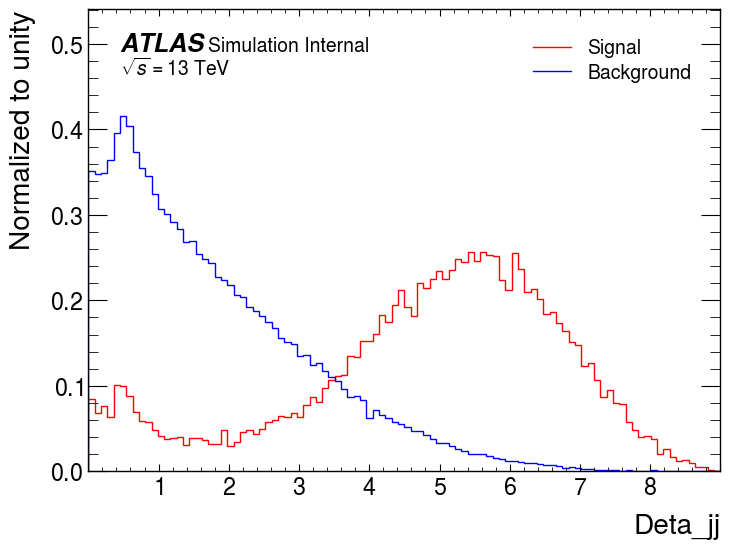

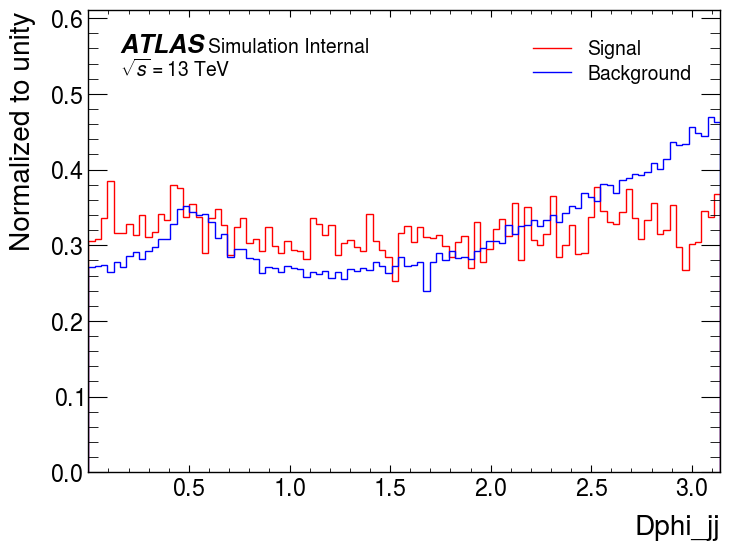

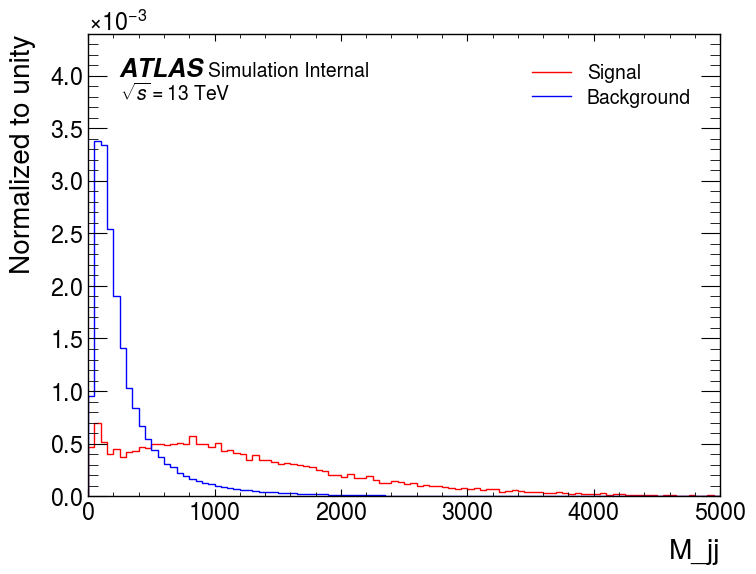

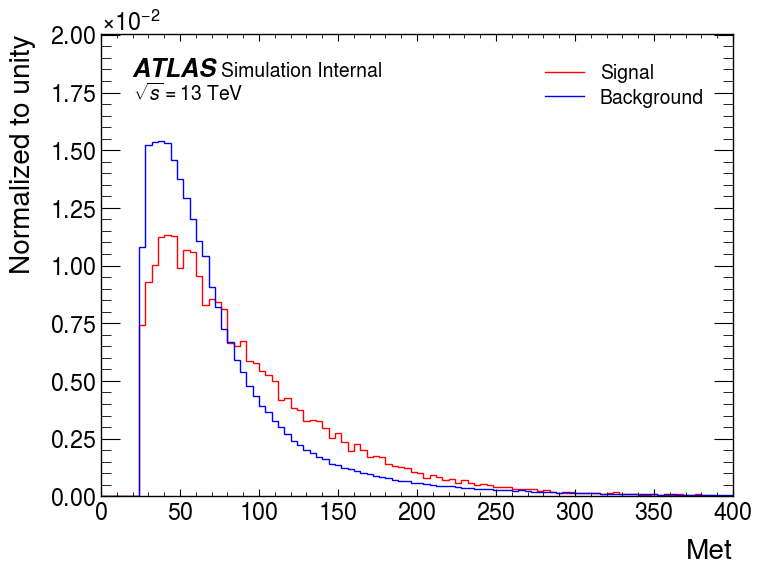

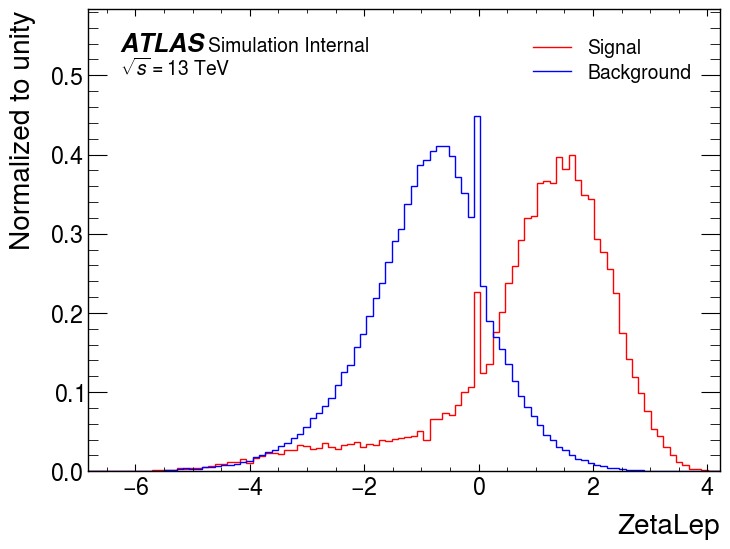

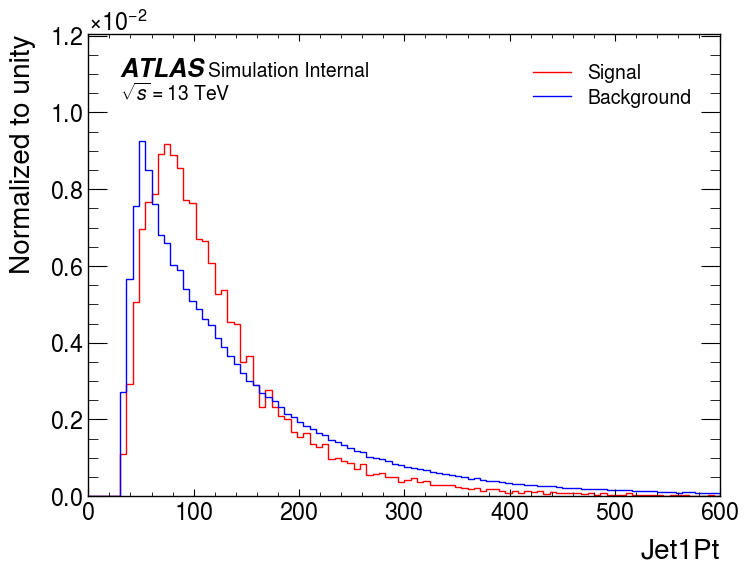

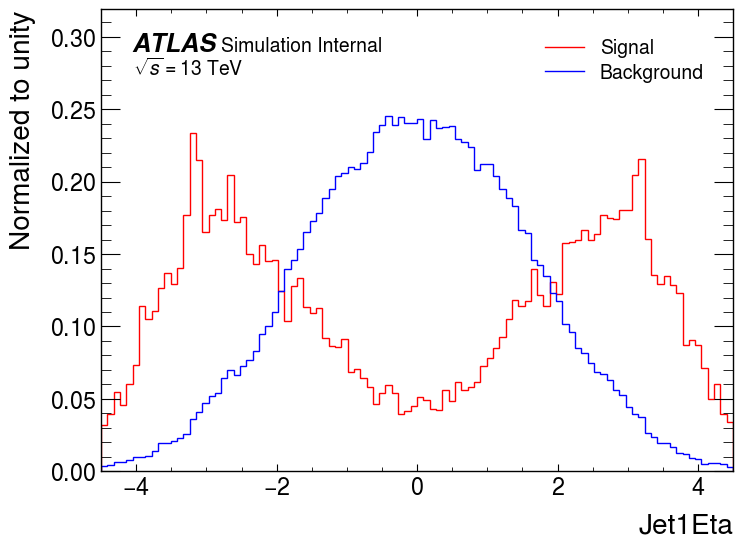

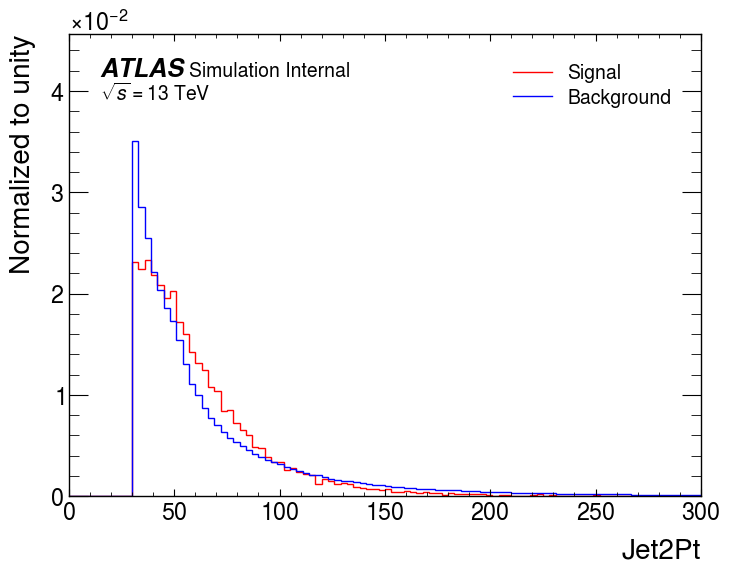

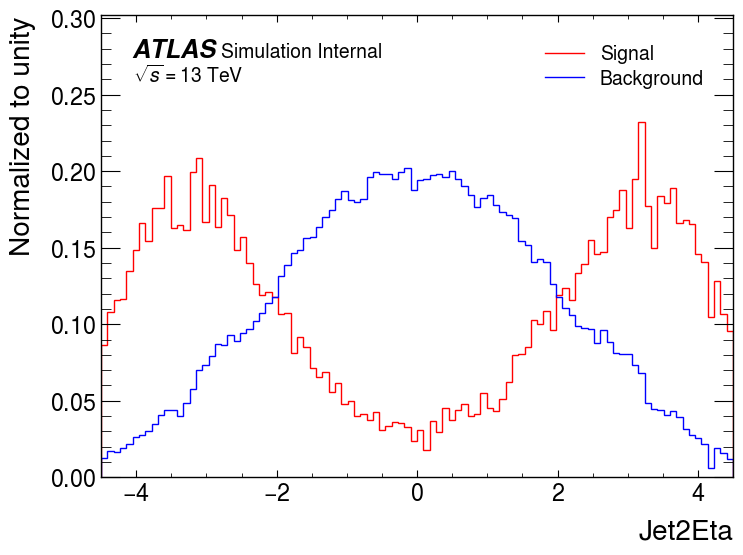

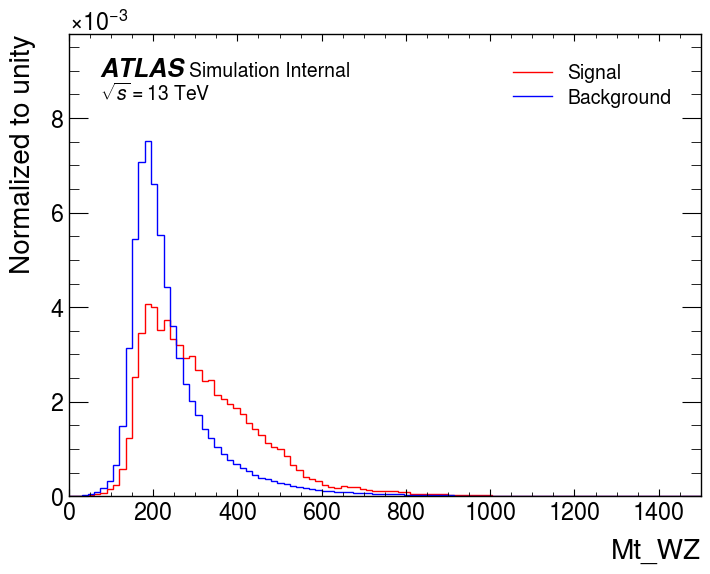

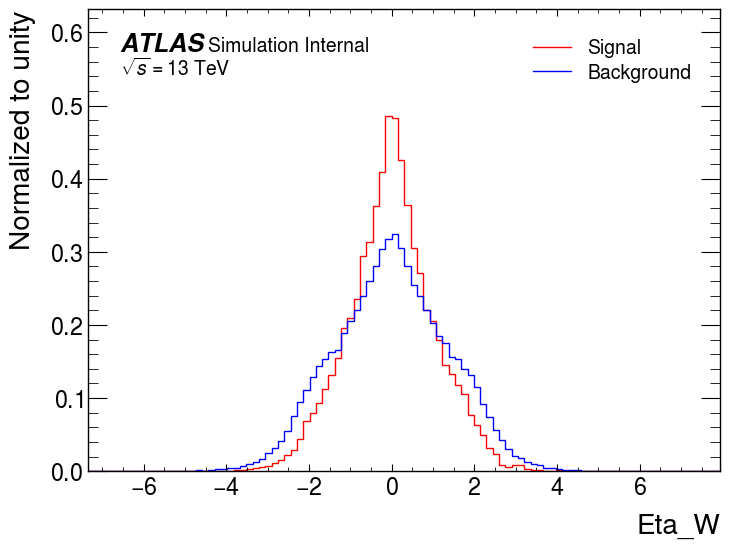

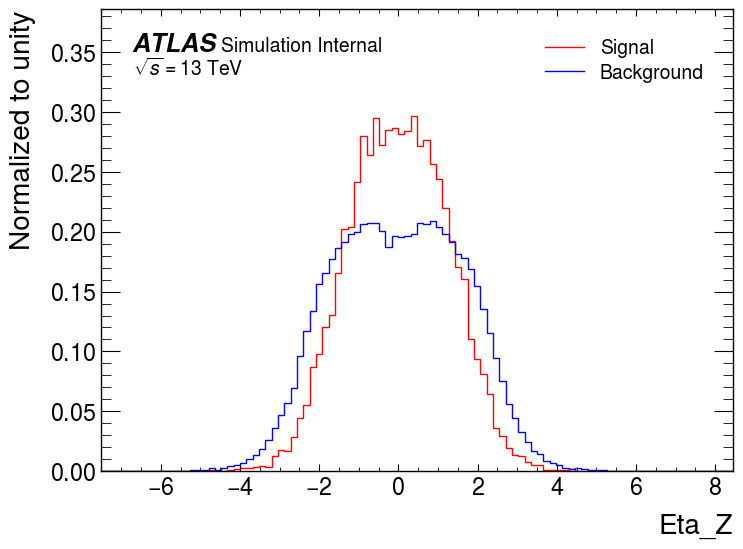

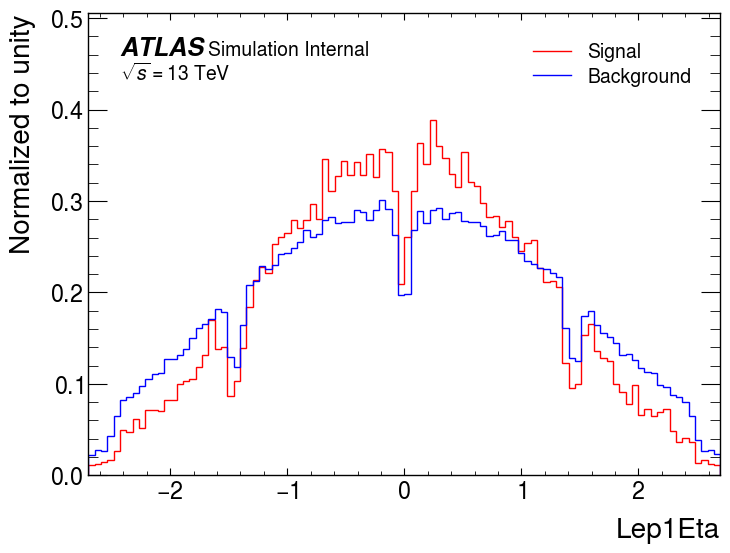

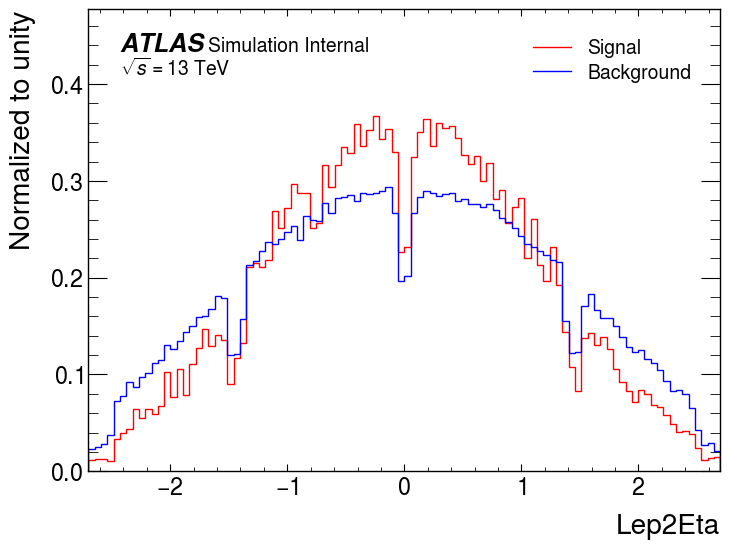

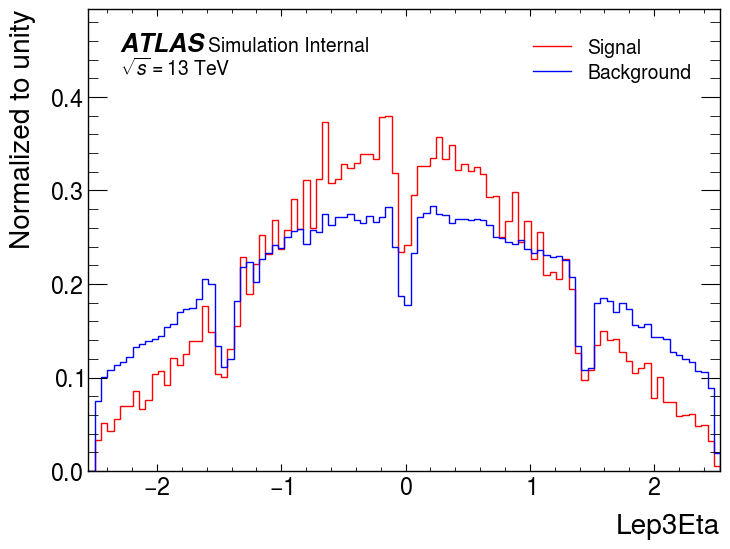

In [132]:
features = [
    "Deta_jj",
    "Dphi_jj",
    "M_jj",
    "Met",
    "ZetaLep",
    "Jet1Pt",
    "Jet1Eta",
    "Jet2Pt",
    "Jet2Eta",
    "Mt_WZ",
    "Eta_W",
    "Eta_Z",
    "Lep1Eta",
    "Lep2Eta",
    "Lep3Eta",
]

for feature in features:
    compare_sigvsbkg(feature, merged_sig, merged_bkg)